<a href="https://www.kaggle.com/code/awesomeharris/ps3e16-regression-with-a-crab-age-dataset?scriptVersionId=131782708" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.model_selection import cross_val_score

# Basic Data Exploration

In [2]:
path1 = "/kaggle/input/playground-series-s3e16/"
path2 = "/kaggle/input/syntheticcrabagedata/"

sample = pd.read_csv(path1+"sample_submission.csv")
train = pd.read_csv(path1+"train.csv")
test = pd.read_csv(path1+"test.csv")
extra = pd.read_csv(path2+"synthetic_data.csv")

# Combine playground dataset and synthetic dataset generated
# train = pd.concat([train,extra]).reset_index(drop=True)

id_test = test['id'] # id column required for submission file
target = 'Age'

In [3]:
def summary(df, name):
    print(f"Head of the '{name}' dataframe:")
    display(df.head())
    
    print(f"Summary of the '{name}' dataframe: \n---->  {df.shape[1]} features and {df.shape[0]} examples.")
    summary = pd.DataFrame(index=df.columns)
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summary["Count"] = desc['count'].values.astype(int)
    summary["Unique"] = df.nunique().values
    summary["Null Count"] = df.isnull().sum().values
    summary["Null (%)"] = (df.isnull().sum().values / df.shape[0] * 100).round(1)
    summary["Duplicated"] = df.duplicated().sum()
    summary['Std'] = np.array([round(val, 1) for val in desc['std'].values.tolist()])
    summary["Mode"] = df.mode().values[0]
    summary["Median"] = df.median().round(1)
    summary['Mean'] = np.array([round(val, 1) for val in desc['mean'].values.tolist()])
    summary['Min'] = np.array([round(val, 1) for val in desc['min'].values.tolist()])
    summary['Max'] = np.array([round(val, 1) for val in desc['max'].values.tolist()])
    summary["First Value"] = df.loc[0].values
    summary["Last Value"] = df.loc[df.shape[0]-1].values
    summary["Types"] = df.dtypes
    
    return display(summary)

summary(sample,"Sample Submission")
print("\n")
summary(train,"Train Dataset")
print("\n")
summary(test,"Test Dataset")

Head of the 'Sample Submission' dataframe:


,id,Age
0,74051,10
1,74052,10
2,74053,10
3,74054,10
4,74055,10


Summary of the 'Sample Submission' dataframe: 
---->  2 features and 49368 examples.


,Count,Unique,Null Count,Null (%),Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
id,49368,49368,0,0.0,0,14251.5,74051.0,98734.5,98734.5,74051.0,123418.0,74051,123418,int64
Age,49368,1,0,0.0,0,0.0,10.0,10.0,10.0,10.0,10.0,10,10,int64




Head of the 'Train Dataset' dataframe:


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


Summary of the 'Train Dataset' dataframe: 
---->  10 features and 74051 examples.


,Count,Unique,Null Count,Null (%),Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
id,74051,74051,0,0.0,0,21376.8,0,37025.0,37025.0,0.0,74050.0,0,74050,int64
Sex,74051,3,0,0.0,0,NaN,M,NaN,NaN,NaN,NaN,I,I,object
Length,74051,144,0,0.0,0,0.3,1.5625,1.4,1.3,0.2,2.0,1.525,0.9125,float64
Diameter,74051,122,0,0.0,0,0.2,1.125,1.1,1.0,0.1,1.6,1.175,0.675,float64
Height,74051,65,0,0.0,0,0.1,0.375,0.4,0.3,0.0,2.8,0.375,0.2,float64
Weight,74051,3096,0,0.0,0,12.6,32.162508,23.8,23.4,0.1,80.1,28.973189,5.386405,float64
Shucked Weight,74051,1766,0,0.0,0,5.6,9.879801,9.9,10.1,0.0,42.2,12.728926,2.055339,float64
Viscera Weight,74051,967,0,0.0,0,2.8,5.868347,5.0,5.1,0.0,21.5,6.647958,1.034757,float64
Shell Weight,74051,1048,0,0.0,0,3.6,7.796112,6.9,6.7,0.0,28.5,8.348928,1.70097,float64
Age,74051,28,0,0.0,0,3.2,9.0,10.0,10.0,1.0,29.0,9,6,int64




Head of the 'Test Dataset' dataframe:


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


Summary of the 'Test Dataset' dataframe: 
---->  9 features and 49368 examples.


,Count,Unique,Null Count,Null (%),Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
id,49368,49368,0,0.0,0,14251.5,74051,98734.5,98734.5,74051.0,123418.0,74051,123418,int64
Sex,49368,3,0,0.0,0,NaN,M,NaN,NaN,NaN,NaN,I,M,object
Length,49368,140,0,0.0,0,0.3,1.5625,1.4,1.3,0.2,2.0,1.05,1.6625,float64
Diameter,49368,122,0,0.0,0,0.2,1.125,1.1,1.0,0.1,1.6,0.7625,1.3,float64
Height,49368,57,0,0.0,0,0.1,0.375,0.4,0.3,0.0,2.8,0.275,0.4375,float64
Weight,49368,2948,0,0.0,0,12.6,32.162508,23.8,23.5,0.1,80.1,8.618248,36.613379,float64
Shucked Weight,49368,1692,0,0.0,0,5.6,9.879801,10.0,10.1,0.0,42.2,3.657085,14.911837,float64
Viscera Weight,49368,938,0,0.0,0,2.8,5.868347,5.0,5.1,0.0,21.5,1.729319,8.292229,float64
Shell Weight,49368,987,0,0.0,0,3.6,8.930093,6.9,6.7,0.0,28.5,2.721552,10.489315,float64


In [4]:
train.shape, test.shape

((74051, 10), (49368, 9))

### Check for presence of nulls

In [5]:
train.isnull().any()

id                False
Sex               False
Length            False
Diameter          False
Height            False
Weight            False
Shucked Weight    False
Viscera Weight    False
Shell Weight      False
Age               False
dtype: bool

no missing null values in train dataset

### Summary statistics for numerical features

In [6]:
numerical_features = train.select_dtypes(include=[np.number]).drop(columns=['id'])
numerical_features.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
Length,74051.0,1.317,0.288,0.188,1.150,1.375,1.538,2.013
Diameter,74051.0,1.024,0.237,0.138,0.888,1.075,1.200,1.612
Height,74051.0,0.348,0.092,0.000,0.300,0.362,0.412,2.825
Weight,74051.0,23.385,12.648,0.057,13.438,23.799,32.163,80.102
Shucked Weight,74051.0,10.104,5.618,0.028,5.712,9.908,14.033,42.184
Viscera Weight,74051.0,5.058,2.793,0.043,2.863,4.990,6.988,21.546
Shell Weight,74051.0,6.724,3.584,0.043,3.969,6.931,9.072,28.491
Age,74051.0,9.968,3.175,1.000,8.000,10.000,11.000,29.000


### Summary statistics for categorical features

In [7]:
categorical_features = train.select_dtypes(include=[object])
categorical_features.describe().T

,count,unique,top,freq
Sex,74051,3,M,27084


In [8]:
train.columns, test.columns, extra.columns

(Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
        'Viscera Weight', 'Shell Weight', 'Age'],
       dtype='object'),
 Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
        'Viscera Weight', 'Shell Weight'],
       dtype='object'),
 Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
        'Viscera Weight', 'Shell Weight', 'Age'],
       dtype='object'))

## Observation by @EPIKT on Gender

In [9]:
train['Sex'].unique()

array(['I', 'M', 'F'], dtype=object)

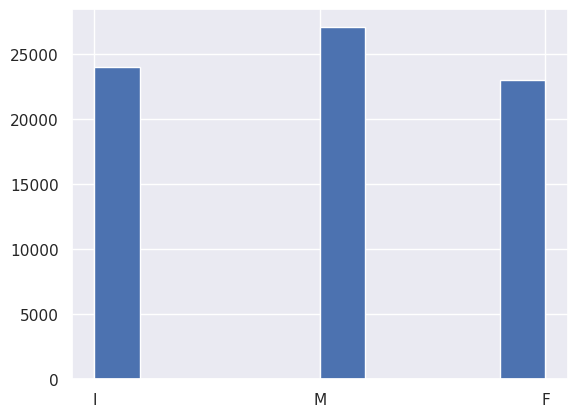

In [10]:
plt.hist(train.Sex);

In [11]:
import lightgbm as lgb

for val in ['I', 'M', 'F']:
    cur_train_df = train.loc[train.Sex == val]
    X = cur_train_df.drop(['Sex', 'Age'], axis=1)
    y = cur_train_df.Age
    
    model = lgb.LGBMRegressor(random_state=0)
    print(val, X.shape)
    print('MAE:', -np.mean(cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')), '\n')

I (23957, 8)
MAE: 0.8964118833354447 

M (27084, 8)
MAE: 1.5901353252450712 

F (23010, 8)
MAE: 1.7382036921488382 



As observed by @EPIKT, the 'Sex' distribution is roughly equal across the dataset but generated different validation scores. (https://www.kaggle.com/code/epiktistes/sexual-dimorphism-in-crabs)

Inference: 
- Feature 'Sex' has significant impact on MAE score. 
- To take advantage of this, we can try encoding the 'Sex' feature using one-hot encoding or even target encoding. 
- Label encoding is not suitable here as there is no ordinal relationship between the unique values.

# Dataset Feature Distributions

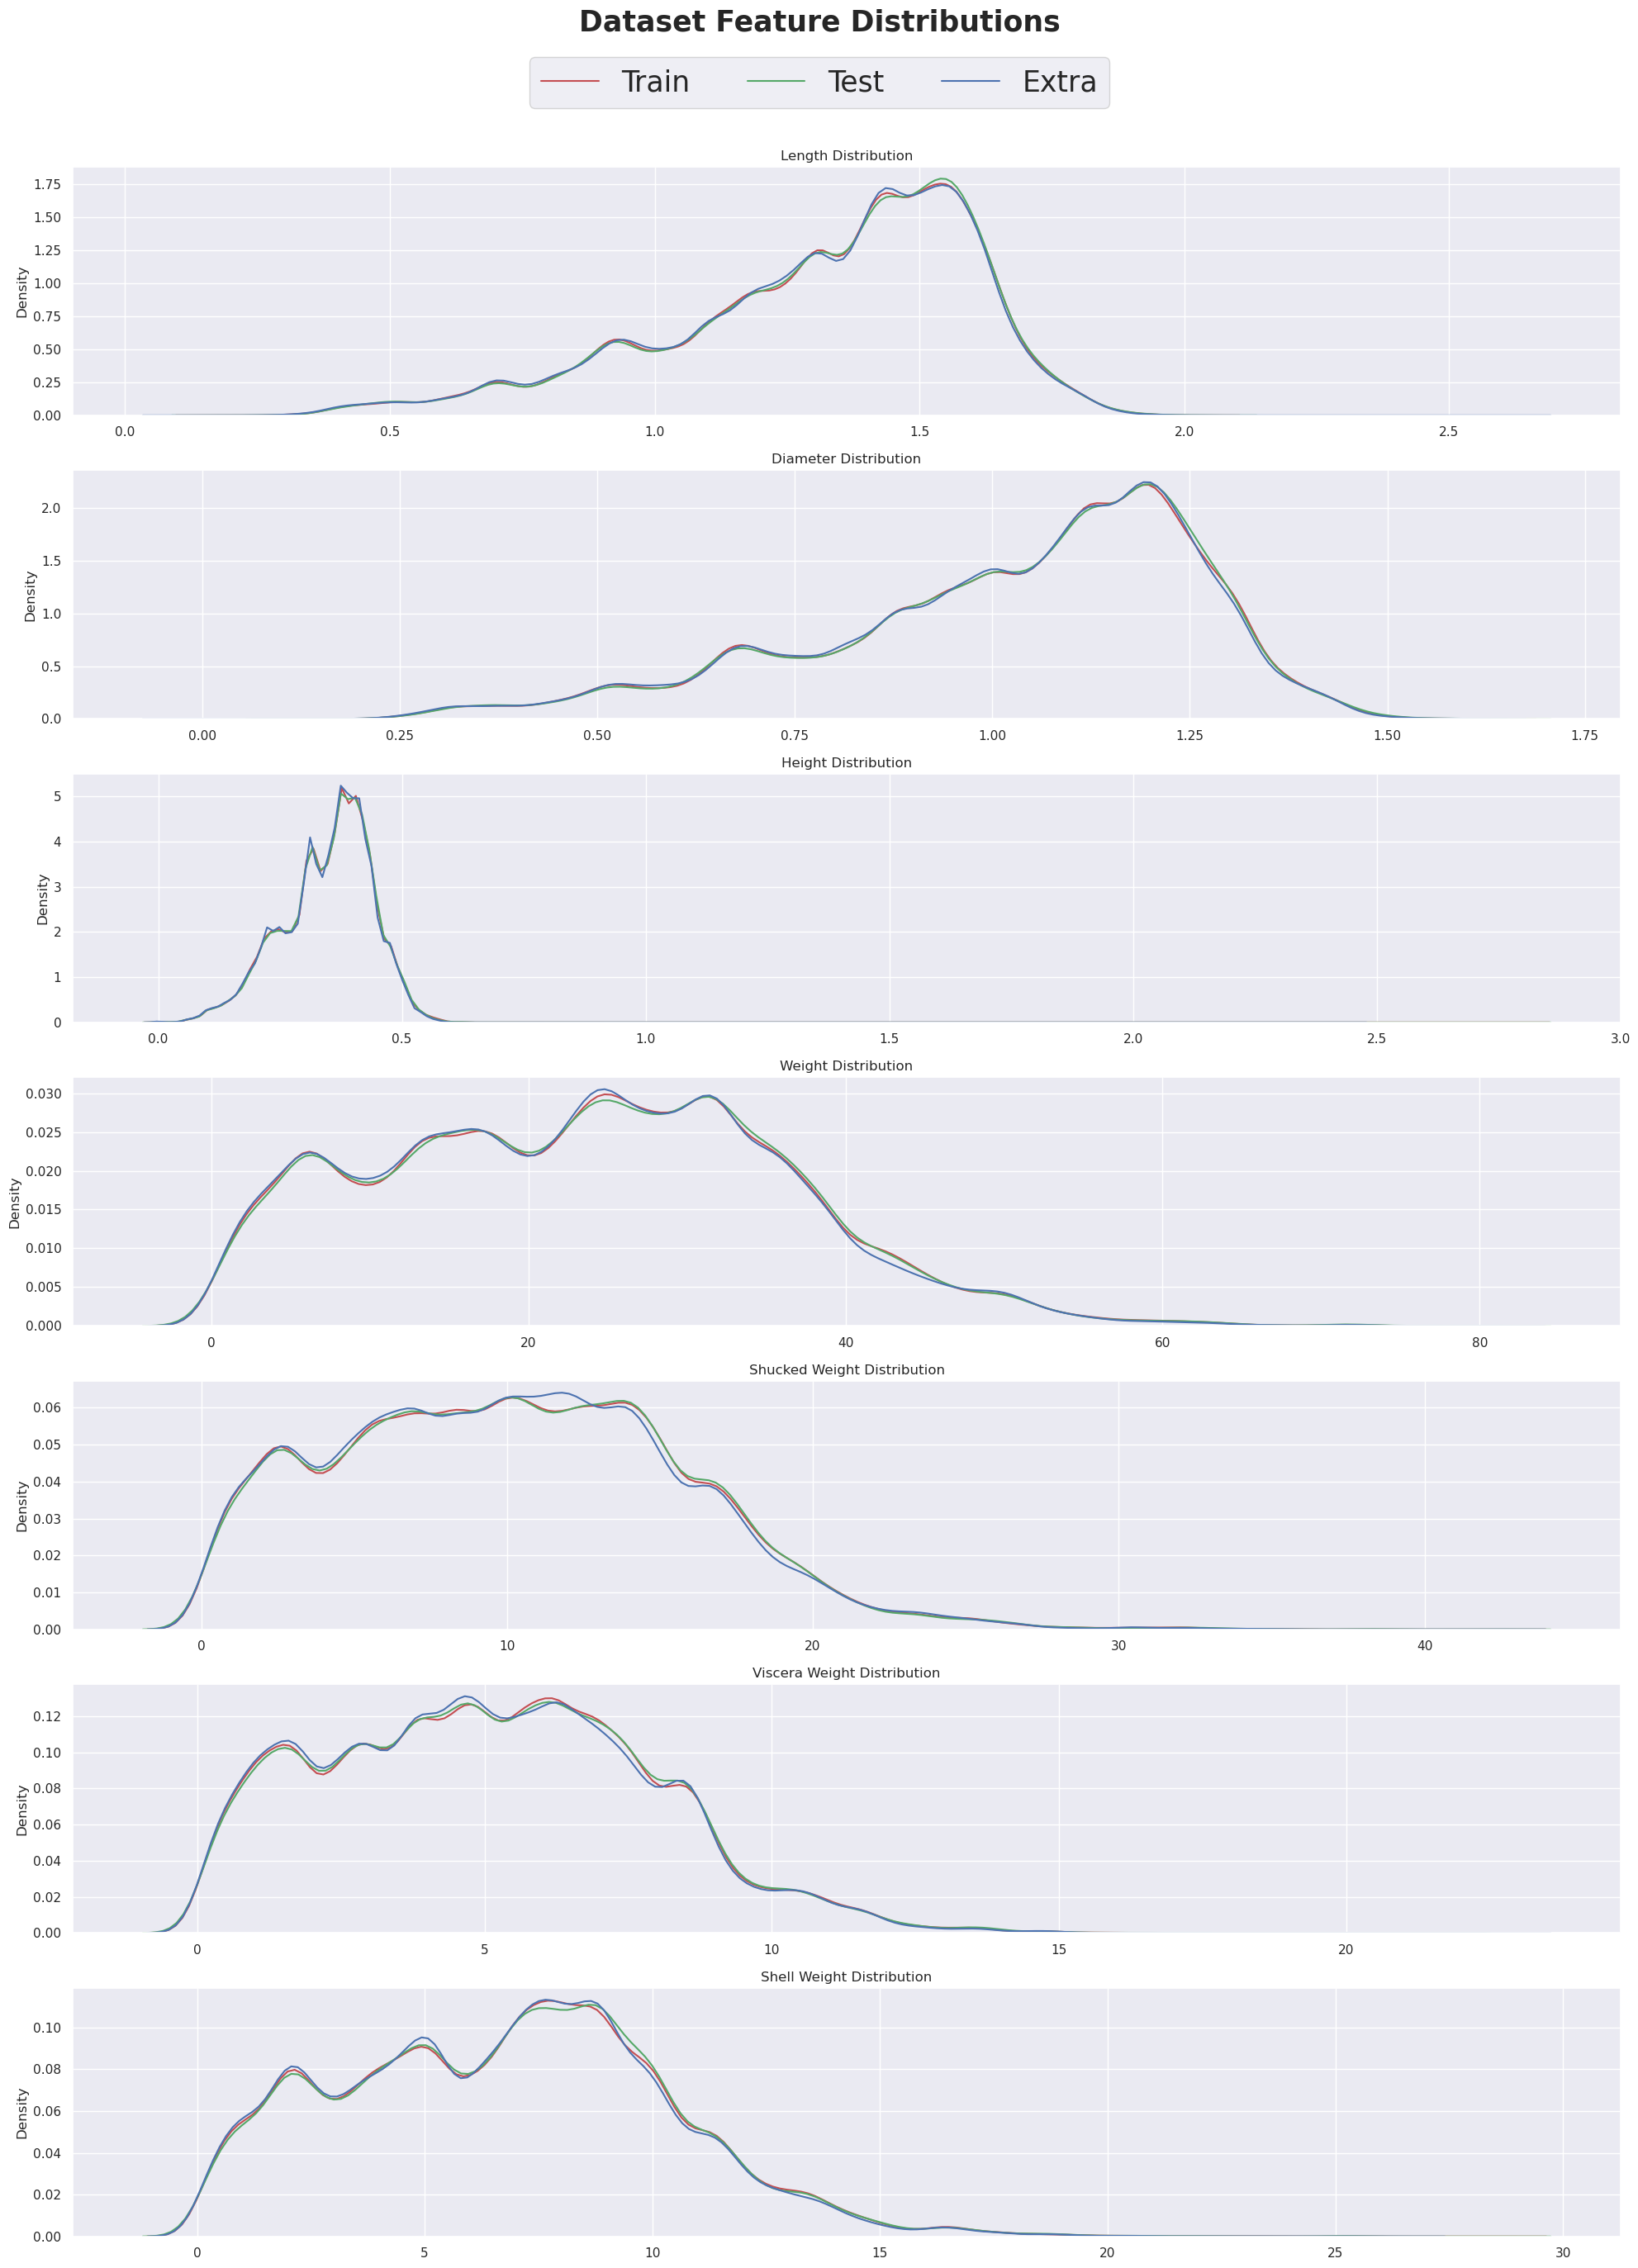

In [12]:
# kudos to @jcaliz
import math
features = train.columns.drop([target,'id','Sex'])
n_bins = 100
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 1
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='r'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='g'
    )
    
    sns.kdeplot(
        extra[column], label='Extra',
        ax=ax[i], color='b'
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=25, ncol=3)
plt.tight_layout()

# Correlation Heatmap (Check for Multicollinearity)

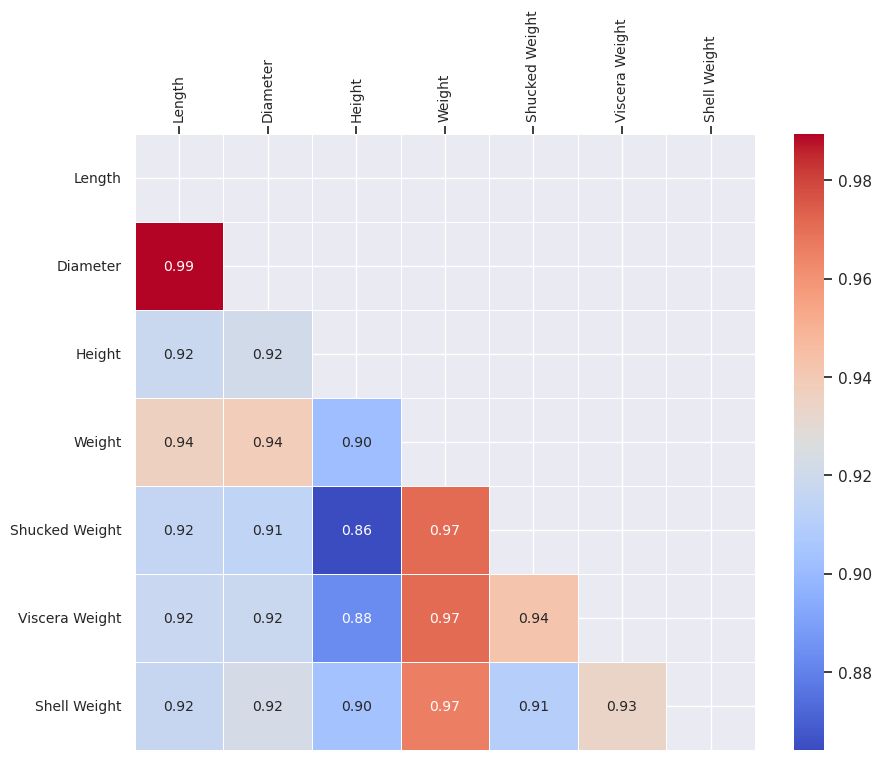

In [13]:
df = train.drop(columns=['id',target])

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a mask to hide the upper triangular portion
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the figure size
plt.figure(figsize=(10, 8))

# Plot the correlation heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', \
            fmt=".2f", linewidths=0.5, annot_kws={"size": 10})

# Adjust the font size of the annotations
plt.tick_params(axis='both', which='both', labelsize=10)

# Change x-axis legend position to top
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=90)

# Display the heatmap
plt.show()

Interestingly, all features are highly correlated! 

# Correlation with Target

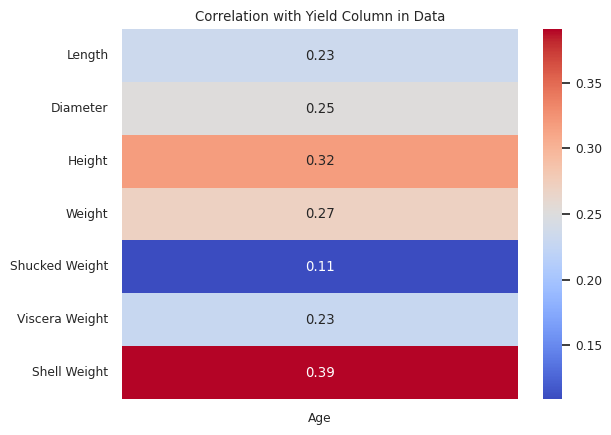

In [14]:
X_corr = train.copy()
X_corr[target] = y
corr = X_corr.corr()

# Extract the correlations with the target column
target_corr = corr[target].drop([target, 'id'])

# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Yield Column in Data')
plt.show()

# Feature Engineering

In [15]:
def create_features(df):
    #cols_to_drop = [target, 'id'] # target is also dropped in data pipeline
    #df = df.drop(cols_to_drop, axis=1)
    
    return df   

# Create a Data Pipeline

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
])

# Update categorical and numerical columns
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns

# Remove target variable from numerical columns
numerical_columns = numerical_columns.drop([target, 'id'])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('create_features', FunctionTransformer(create_features, validate=False)),
    ('preprocessor', preprocessor),
])

# Apply the pipeline to your dataset
cols_to_drop = [target, 'id']
X = train.drop(cols_to_drop,axis=1)
y = train[target] 
X_preprocessed = pipeline.fit(X)
X_preprocessed = X_preprocessed.transform(X)

In [17]:
# View the post-processed dataframe

from sklearn import set_config

# Set scikit-learn config to use the new 'newton-cg' solver for logistic regression
set_config(display='diagram')

# Get the column names after preprocessing
column_names = list(numerical_columns) + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns))

# Convert the transformed data into a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=column_names)

# Print the post-processed dataframe
X_preprocessed_df.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,0.721238,0.633982,0.292400,0.441804,0.467188,0.569186,0.453376,0.0,1.0,0.0
1,-0.755712,-0.840356,-0.794163,-1.025198,-0.993688,-0.978880,-0.926788,0.0,1.0,0.0
2,0.243401,0.370707,0.292400,0.110076,0.219924,0.178363,-0.017224,0.0,0.0,1.0
3,1.329394,1.634426,1.650603,2.156483,1.824616,2.124622,2.308095,1.0,0.0,0.0
4,-0.234435,-0.050532,-0.115061,-0.007598,0.333464,-0.197233,-0.214955,0.0,1.0,0.0


# Running some regression models using cross validation on training dataset

In [18]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=42)
print(X_preprocessed.shape)
print('MAE:', -np.mean(cross_val_score(lgbm, X_preprocessed, y, cv=5, scoring='neg_mean_absolute_error')), '\n')

(74051, 10)
MAE: 1.4019744532731948 



In [19]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
print(X_preprocessed.shape)
print('MAE:', -np.mean(cross_val_score(xgb, X_preprocessed, y, cv=5, scoring='neg_mean_absolute_error')), '\n')

(74051, 10)
MAE: 1.4175676387845166 



In [20]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor(random_state=42, verbose=False)
print(X_preprocessed.shape)
print('MAE:', -np.mean(cross_val_score(cbr, X_preprocessed, y, cv=5, scoring='neg_mean_absolute_error')), '\n')

(74051, 10)
MAE: 1.4014398559023409 



In [21]:
"""from sklearn.linear_model import LinearRegression

lr = LinearRegression()
print(X_preprocessed.shape)
print('MAE:', -np.mean(cross_val_score(lr, X_preprocessed, y, cv=5, scoring='neg_mean_absolute_error')), '\n')
"""

"from sklearn.linear_model import LinearRegression\n\nlr = LinearRegression()\nprint(X_preprocessed.shape)\nprint('MAE:', -np.mean(cross_val_score(lr, X_preprocessed, y, cv=5, scoring='neg_mean_absolute_error')), '\n')\n"

In [22]:
"""from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42,verbose=False)
print(X_preprocessed.shape)
print('MAE:', -np.mean(cross_val_score(rfr, X_preprocessed, y, cv=5, scoring='neg_mean_absolute_error')), '\n')
"""

"from sklearn.ensemble import RandomForestRegressor\n\nrfr = RandomForestRegressor(random_state=42,verbose=False)\nprint(X_preprocessed.shape)\nprint('MAE:', -np.mean(cross_val_score(rfr, X_preprocessed, y, cv=5, scoring='neg_mean_absolute_error')), '\n')\n"

# Ensemble the top 3 models

In [23]:
from sklearn.ensemble import VotingRegressor

# Combine the base models to create an ensemble and assign weights
weights = [0.2, 0.2, 0.6]
# Combine the base models to create an ensemble
ensemble = VotingRegressor([('xgb', xgb), 
                            ('lgbm', lgbm), 
                            ('catboost', cbr)], 
                           weights=weights)
# Train the ensemble model using selected features
ensemble.fit_transform(X_preprocessed, y)

print('MAE:', -np.mean(cross_val_score(ensemble, X_preprocessed, y, cv=5, scoring='neg_mean_absolute_error')), '\n')

# Perform prediction on validation data
# y_pred = ensemble.predict(X_pre_processed)
# mae = mean_absolute_error(y_pred, y_valid)
# print("Mean Absolute Error:" , mae)

MAE: 1.3980118929707257 



# Final Prediction

In [24]:
X_test = test.drop("id",axis=1)
X_test = pipeline.fit_transform(X_test)
y_pred = ensemble.predict(X_test)


output = pd.DataFrame({'id':id_test, 'Age':y_pred.round(1)})
print(output.head())

      id   Age
0  74051   7.6
1  74052   7.8
2  74053  11.0
3  74054   9.5
4  74055   7.5


In [25]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
